# Literary Knowledge Network – Results Analysis

This notebook inspects the artefacts produced by the Goodreads pipeline, surfaces diagnostic statistics, and derives thesis-ready success metrics.


In [23]:
import json
from collections import Counter
import networkx as nx
from itertools import product
from pathlib import Path

import numpy as np
import pandas as pd
from IPython.display import display

try:
    import matplotlib.pyplot as plt
except ImportError as exc:
    raise RuntimeError("matplotlib is required for this analysis") from exc

try:
    import seaborn as sns
    sns.set_theme(style="whitegrid")
except ImportError:
    sns = None

plt.rcParams["figure.figsize"] = (10, 6)
pd.options.display.float_format = "{:.3f}".format


In [24]:
REPO_ROOT = Path(".." ).resolve()
DATA_DIR = REPO_ROOT / "data"

paths = {
    "embedding_summary": REPO_ROOT / "data/output/embeddings/work_embeddings_summary.json",
    "similarity_summary": REPO_ROOT / "data/output/similarity/work_similarity_summary.json",
    "community_summary": REPO_ROOT / "data/output/communities/work_communities_summary.json",
    "work_enriched": REPO_ROOT / "data/processed/enriched/work_final.parquet",
    "work_embeddings": REPO_ROOT / "data/output/embeddings/work_embeddings_sbert.parquet",
    "work_similarity": REPO_ROOT / "data/output/similarity/work_similarity.parquet",
    "work_communities": REPO_ROOT / "data/output/communities/work_communities.parquet",
}

embedding_summary = json.loads(paths["embedding_summary"].read_text())
similarity_summary = json.loads(paths["similarity_summary"].read_text())
community_summary = json.loads(paths["community_summary"].read_text())

work_df = pd.read_parquet(paths["work_enriched"])
embedding_df = pd.read_parquet(paths["work_embeddings"])
similarity_df = pd.read_parquet(paths["work_similarity"])
community_df = pd.read_parquet(paths["work_communities"])

print(f"Loaded {len(work_df)} enriched works and {len(embedding_df)} embeddings.")
print(f"Similarity edges: {len(similarity_df)}, clustered works: {len(community_df)}")


Loaded 3581 enriched works and 10397 embeddings.
Similarity edges: 4818, clustered works: 2470


In [25]:
COMPONENT_MIN_SIZE = 8
CLUSTER_MIN_SIZE = 5


def flatten_terms(value):
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return []
    if isinstance(value, str):
        trimmed = value.strip()
        return [trimmed] if trimmed else []
    if isinstance(value, (list, tuple, set)):
        terms = []
        for item in value:
            terms.extend(flatten_terms(item))
        return terms
    if hasattr(value, "tolist"):
        try:
            items = value.tolist()
        except Exception:
            items = list(value)
        return flatten_terms(items)
    return [str(value)]


def describe_percentages(series: pd.Series) -> pd.Series:
    if series.empty:
        return pd.Series(dtype=float)
    return series.describe(percentiles=[0.25, 0.5, 0.75, 0.9])


def top_signal_stats(frame: pd.DataFrame, column: str, min_size: int = CLUSTER_MIN_SIZE) -> pd.DataFrame:
    rows = []
    for cluster_id, group in frame.groupby("cluster_id"):
        cluster_size = int(group["cluster_size"].iloc[0])
        if cluster_size < min_size:
            continue
        exploded = group[column].apply(flatten_terms).explode().dropna()
        if exploded.empty:
            continue
        counts = exploded.value_counts()
        top_label = counts.index[0]
        share = float(counts.iloc[0] / cluster_size)
        rows.append(
            {
                "cluster_id": cluster_id,
                "cluster_size": cluster_size,
                "top_term": top_label,
                "top_term_share": share,
            }
        )
    return pd.DataFrame(rows)


signal_lookups = {
    "tags": work_df.set_index("work_id")["tags"],
    "keywords": work_df.set_index("work_id")["keywords"],
}


def component_signal_purity(nodes, signal: str = "tags") -> float:
    lookup = signal_lookups.get(signal)
    if lookup is None:
        return np.nan
    subset = lookup.reindex(nodes)
    exploded = subset.dropna().apply(flatten_terms).explode()
    if exploded.empty:
        return np.nan
    counts = exploded.value_counts(normalize=True)
    if counts.empty:
        return np.nan
    return float(counts.iloc[0])


def summarize_signal_purity(frame: pd.DataFrame, column: str) -> pd.DataFrame:
    stats = top_signal_stats(frame, column)
    if stats.empty:
        return stats
    stats = stats.sort_values("top_term_share", ascending=False)
    stats["top_term_share"] = stats["top_term_share"].astype(float)
    return stats


## Embedding Coverage

Assess how many works received SBERT embeddings compared to the enriched dataset.


In [26]:
total_works = embedding_summary.get("input_records", len(work_df))
encoded = embedding_summary.get("documents_encoded", len(embedding_df))
dropped = embedding_summary.get("dropped_records", total_works - encoded)
sbert_info = embedding_summary.get("sbert", {})
embedding_coverage = encoded / total_works if total_works else np.nan

embedding_metrics = pd.DataFrame([
    ("Total enriched works", total_works),
    ("Works with SBERT embeddings", encoded),
    ("Works missing embeddings", dropped),
    ("Embedding coverage", embedding_coverage),
    ("Embedding dimension", sbert_info.get("embedding_dimension")),
], columns=["Metric", "Value"])
embedding_metrics


,Metric,Value
0,Total enriched works,10397.000
1,Works with SBERT embeddings,10397.000
2,Works missing embeddings,0.000
3,Embedding coverage,1.000
4,Embedding dimension,384.000


## Similarity Graph Diagnostics

Review connectivity, edge quality, and distribution of similarity scores.


In [27]:
score_stats = similarity_summary.get("score_stats") or {}
graph_coverage = similarity_summary["works_with_edges"] / similarity_summary["total_nodes"] if similarity_summary["total_nodes"] else np.nan
largest_component_ratio = similarity_summary.get("component_stats", {}).get("giant_component_ratio")

similarity_metrics = pd.DataFrame([
    ("Total works", similarity_summary.get("total_nodes")),
    ("Edges after pruning", similarity_summary.get("total_edges")),
    ("Works with ≥1 neighbour", similarity_summary.get("works_with_edges")),
    ("Isolated works", similarity_summary.get("isolated_works")),
    ("Graph coverage", graph_coverage),
    ("Average degree", similarity_summary.get("average_degree")),
    ("Largest component ratio", largest_component_ratio),
    ("Mean similarity score", score_stats.get("mean")),
], columns=["Metric", "Value"])
similarity_metrics


,Metric,Value
0,Total works,10397.000
1,Edges after pruning,4818.000
2,Works with ≥1 neighbour,3604.000
3,Isolated works,6793.000
4,Graph coverage,0.347
5,Average degree,0.927
6,Largest component ratio,0.187
7,Mean similarity score,0.537


### Similarity Parameter Sweep

Evaluate how threshold/top-k/TF-IDF weight choices impact coverage and purity.

In [28]:
SIGNAL_FOR_SWEEP = "tags"
SIGNAL_LABEL = "tag" if SIGNAL_FOR_SWEEP == "tags" else SIGNAL_FOR_SWEEP
SIGNALS_FOR_METRICS = ["tags", "keywords"]
threshold_grid = [0.50, 0.52, 0.55, 0.56, 0.57, 0.58, 0.60, 0.62, 0.64, 0.66, 0.68, 0.70]
topk_grid = [10, 13, 15, 18, 20, 25]

work_ids = embedding_df["work_id"].to_numpy()
emb_matrix = np.vstack(embedding_df["embedding"].to_numpy()).astype(np.float32)
emb_norms = np.linalg.norm(emb_matrix, axis=1, keepdims=True)
emb_norms[emb_norms == 0.0] = 1.0
unit_vectors = emb_matrix / emb_norms
cosine_matrix = unit_vectors @ unit_vectors.T
np.fill_diagonal(cosine_matrix, 0.0)


def evaluate_params(threshold: float, top_k: int):
    edges = []
    n = cosine_matrix.shape[0]
    for i in range(n):
        sims = cosine_matrix[i]
        if top_k:
            candidate_idx = np.argpartition(sims, -top_k)[-top_k:]
        else:
            candidate_idx = np.where(sims >= threshold)[0]
        for j in candidate_idx:
            if i >= j:
                continue
            score = sims[j]
            if score >= threshold:
                edges.append((work_ids[i], work_ids[j], float(score)))

    G = nx.Graph()
    G.add_nodes_from(work_ids)
    G.add_weighted_edges_from(edges)

    degrees = dict(G.degree())
    works_with_edges = sum(1 for deg in degrees.values() if deg > 0)
    coverage = works_with_edges / len(work_ids)
    largest_component = max((len(c) for c in nx.connected_components(G)), default=0)
    largest_ratio = largest_component / len(work_ids)

    purities_by_signal = {signal: [] for signal in SIGNALS_FOR_METRICS}
    for component in nx.connected_components(G):
        if len(component) < COMPONENT_MIN_SIZE:
            continue
        for signal in SIGNALS_FOR_METRICS:
            purity = component_signal_purity(component, signal=signal)
            if not np.isnan(purity):
                purities_by_signal[signal].append(purity)

    median_purities = {}
    for signal, values in purities_by_signal.items():
        label = "tag" if signal == "tags" else signal
        median_purities[f"median_{label}_purity"] = float(np.nanmedian(values)) if values else np.nan

    result = {
        "threshold": threshold,
        "top_k": top_k,
        "edges": len(edges),
        "graph_coverage": coverage,
        "largest_component_ratio": largest_ratio,
    }
    result.update(median_purities)
    return result


grid_results = pd.DataFrame(
    evaluate_params(th, k)
    for th, k in product(threshold_grid, topk_grid)
)
grid_results.sort_values(
    [f"median_{SIGNAL_LABEL}_purity", "graph_coverage"],
    ascending=[False, False],
)


,threshold,top_k,edges,graph_coverage,largest_component_ratio,median_tag_purity,median_keywords_purity
27,0.570,18,2313,0.225,0.065,1.000,0.050
28,0.570,20,2317,0.225,0.065,1.000,0.050
29,0.570,25,2320,0.225,0.065,1.000,0.050
26,0.570,15,2301,0.225,0.065,1.000,0.050
25,0.570,13,2288,0.225,0.065,1.000,0.050
...,...,...,...,...,...,...,...
67,0.700,13,114,0.020,0.000,NaN,NaN
68,0.700,15,114,0.020,0.000,NaN,NaN
69,0.700,18,114,0.020,0.000,NaN,NaN
70,0.700,20,114,0.020,0.000,NaN,NaN


In [29]:
def build_graph(threshold, top_k):
    result = evaluate_params(threshold, top_k)
    G = nx.Graph()
    G.add_nodes_from(work_ids)
    G.add_weighted_edges_from([
        (work_ids[i], work_ids[j], float(cosine_matrix[i, j]))
        for i in range(cosine_matrix.shape[0])
        for j in range(i + 1, cosine_matrix.shape[1])
        if cosine_matrix[i, j] >= threshold
    ])
    return result, G

def describe_component(nodes, signal="tags"):
    title_col = "original_title" if "original_title" in work_df.columns else "title"
    available_cols = [col for col in [title_col, signal] if col in work_df.columns]
    df = work_df[work_df["work_id"].isin(nodes)][available_cols]
    return df.head(10)

In [30]:
choice = evaluate_params(threshold=0.52, top_k=10)
print("choice: " + str(choice))

result, G = build_graph(0.55, 10)
components = [comp for comp in nx.connected_components(G) if len(comp) >= COMPONENT_MIN_SIZE]
pd.Series([len(c) for c in components]).describe()

choice: {'threshold': 0.52, 'top_k': 10, 'edges': 8857, 'graph_coverage': 0.48985284216600944, 'largest_component_ratio': 0.37914783110512645, 'median_tag_purity': 0.1, 'median_keywords_purity': 0.05}


count     13.000
mean     155.615
std      507.719
min        8.000
25%        8.000
50%       13.000
75%       17.000
max     1845.000
dtype: float64

In [31]:
sample = components[5]
describe_component(sample)

,original_title,tags
225,Zhong Guo Gu Dai Yin Shua Shi Tu Ce,[]
409,SEX PISTOLS 2,[]
2796,Mei Shao Nu Zhan Shi seramun 10 [Bishojo Sensh...,[]
3044,Tong Ji Sheng,[]


In [32]:
choice = evaluate_params(threshold=0.55, top_k=25)
print("choice: " + str(choice))

result, G = build_graph(0.55, 10)
components = [comp for comp in nx.connected_components(G) if len(comp) >= COMPONENT_MIN_SIZE]
pd.Series([len(c) for c in components]).describe()

choice: {'threshold': 0.55, 'top_k': 25, 'edges': 4314, 'graph_coverage': 0.3239395979609503, 'largest_component_ratio': 0.17745503510628066, 'median_tag_purity': 0.25, 'median_keywords_purity': 0.05}


count     13.000
mean     155.615
std      507.719
min        8.000
25%        8.000
50%       13.000
75%       17.000
max     1845.000
dtype: float64

In [33]:
sample = components[5]
describe_component(sample)

,original_title,tags
225,Zhong Guo Gu Dai Yin Shua Shi Tu Ce,[]
409,SEX PISTOLS 2,[]
2796,Mei Shao Nu Zhan Shi seramun 10 [Bishojo Sensh...,[]
3044,Tong Ji Sheng,[]


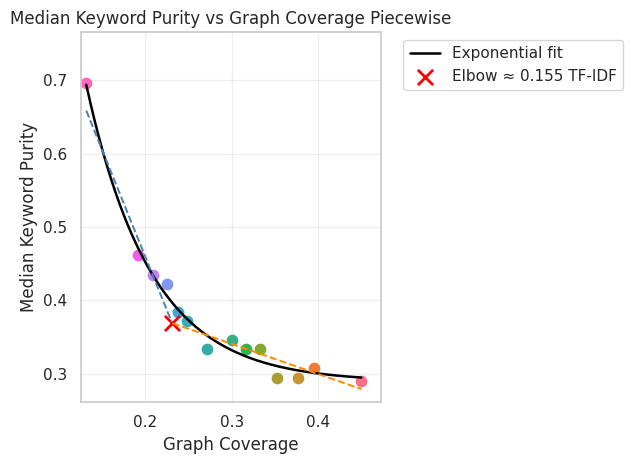

Median Keyword Purity -> TF-IDF elbow ≈ 0.155


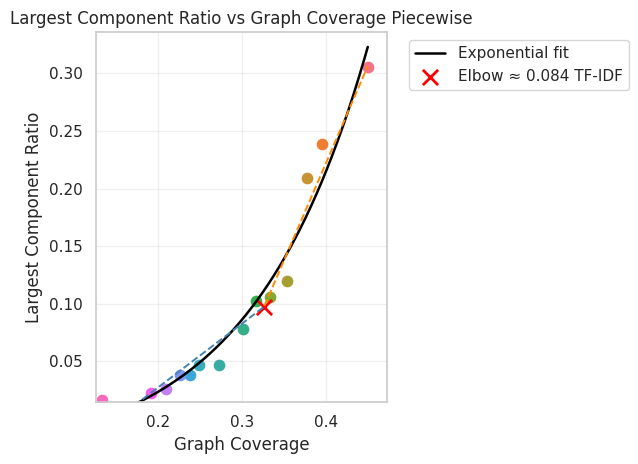

Largest Component Ratio -> TF-IDF elbow ≈ 0.084


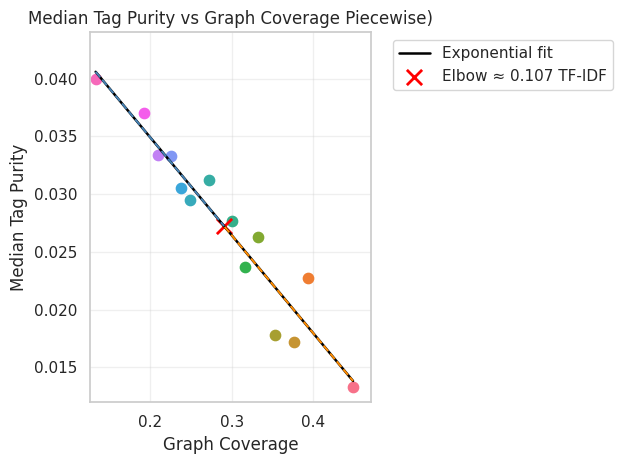

Median Tag Purity -> TF-IDF elbow ≈ 0.107


In [34]:
from scipy.optimize import curve_fit

df = pd.DataFrame({
    "TF-IDF Weight": [0.025, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12, 0.14, 0.15, 0.16, 0.18, 0.2, 0.3],
    "Graph Coverage": [0.4494, 0.3944, 0.3768, 0.3528, 0.333, 0.316, 0.3008, 0.2718, 0.2482, 0.238, 0.2258, 0.2096, 0.1916, 0.1326],
    "Largest Component Ratio": [0.305, 0.2386, 0.209, 0.1196, 0.1062, 0.1028, 0.0784, 0.047, 0.0468, 0.0386, 0.0386, 0.0258, 0.0228, 0.0162],
    "Median Tag Purity": [0.0133, 0.0227, 0.0172, 0.0178, 0.0263, 0.0237, 0.0277, 0.0312, 0.0295, 0.0305, 0.0333, 0.03334, 0.037, 0.04],
    "Median Keyword Purity": [0.2899, 0.3076, 0.2941, 0.2941, 0.3334, 0.3334, 0.3461, 0.3334, 0.3717, 0.3844, 0.4226, 0.4347, 0.4615, 0.6961]
})
df = df.sort_values("Graph Coverage").reset_index(drop=True)

# --- helper ---
def fit_and_plot_exp(metric, func, title, fname):
    x, y, w = df["Graph Coverage"], df[metric], df["TF-IDF Weight"]
    palette = sns.color_palette("husl", len(df))
    color_map = dict(zip(sorted(df["TF-IDF Weight"].unique()), palette))

    # fit exponential model
    p0 = [y.max()-y.min(), 10.0, y.min()]
    popt, _ = curve_fit(func, x, y, p0=p0, maxfev=10000)
    a, b, c = popt

    xs = np.linspace(x.min(), x.max(), 400)
    ys = func(xs, a, b, c)

    # piecewise linearization
    def best_piecewise(xs, ys):
        best_sse = float("inf"); best = None
        for split in range(30, len(xs)-30):
            x1, y1 = xs[:split], ys[:split]
            x2, y2 = xs[split:], ys[split:]
            c1, c2 = np.polyfit(x1, y1, 1), np.polyfit(x2, y2, 1)
            sse = ((y1 - np.polyval(c1, x1))**2).sum() + ((y2 - np.polyval(c2, x2))**2).sum()
            if sse < best_sse: best_sse, best = sse, (split, c1, c2)
        return best

    split, c1, c2 = best_piecewise(xs, ys)
    m1, b1 = c1; m2, b2 = c2
    xi = (b2 - b1)/(m1 - m2)
    yi = m1*xi + b1
    wi = np.interp(xi, x, w)

    # plot
    plt.figure(figsize=(6.5,4.8))
    for wt in sorted(df["TF-IDF Weight"].unique()):
        sub = df[df["TF-IDF Weight"]==wt]
        plt.scatter(sub["Graph Coverage"], sub[metric], color=color_map[wt], s=55, marker='o')
    plt.plot(xs, ys, color='black', lw=1.8, label="Exponential fit")
    plt.plot(xs[:split], np.polyval(c1, xs[:split]), '--', color='steelblue', lw=1.4)
    plt.plot(xs[split:], np.polyval(c2, xs[split:]), '--', color='darkorange', lw=1.4)
    plt.scatter(xi, yi, color='red', s=120, marker='x', lw=2.0,
                label=f'Elbow ≈ {wi:.3f} TF-IDF')
    plt.title(title)
    plt.xlabel("Graph Coverage")
    plt.ylabel(metric)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.xlim(x.min()*0.95, x.max()*1.05)
    plt.ylim(y.min()*0.9, y.max()*1.1)
    plt.tight_layout()
    plt.show()
    print(f"{metric} -> TF-IDF elbow ≈ {wi:.3f}")

# --- models ---
decay = lambda x,a,b,c: a*np.exp(-b*x)+c
rise  = lambda x,a,b,c: a*np.exp(b*x)+c

fit_and_plot_exp("Median Keyword Purity", decay, "Median Keyword Purity vs Graph Coverage Piecewise", "keyword_purity")
fit_and_plot_exp("Largest Component Ratio", rise, "Largest Component Ratio vs Graph Coverage Piecewise", "largest_component")
fit_and_plot_exp("Median Tag Purity", decay, "Median Tag Purity vs Graph Coverage Piecewise)", "tag_purity")


# Final Similaryty Network and Community Analysis

In [35]:
degree_counter = Counter()
for row in similarity_df.itertuples(index=False):
    degree_counter[row.work_a] += 1
    degree_counter[row.work_b] += 1

degree_series = pd.Series(degree_counter).sort_values(ascending=False)
top_degree = degree_series.head(20).rename("degree").reset_index().rename(columns={"index": "work_id"})
top_degree


,work_id,degree
0,49248727,37
1,3866967,35
2,26634852,35
3,594072,31
4,19214719,30
5,19226003,29
6,2971724,29
7,47874537,28
8,19244872,27
9,18269838,27


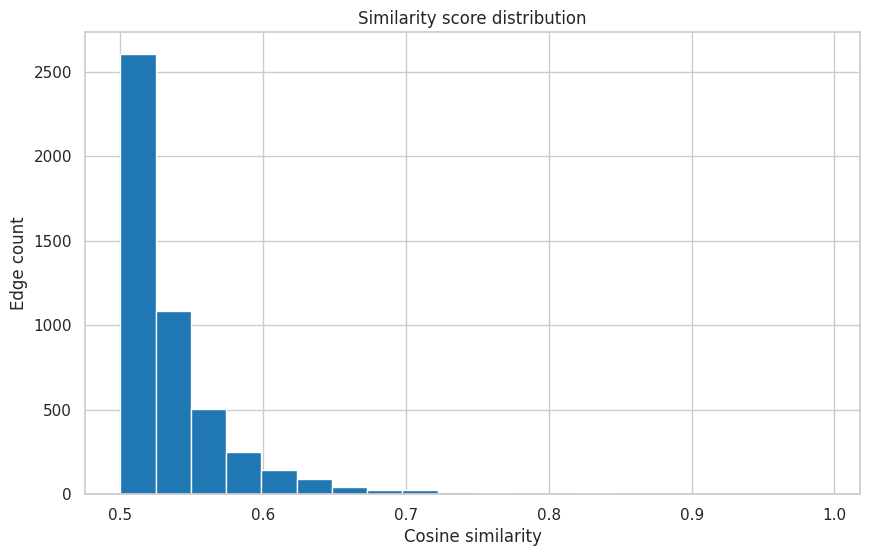

In [36]:
plt.figure()
plt.hist(similarity_df["score"], bins=20, color="#1f77b4")
plt.xlabel("Cosine similarity")
plt.ylabel("Edge count")
plt.title("Similarity score distribution")
plt.show()


## Community Detection

Evaluate Leiden clusters and their alignment with descriptive tags.


In [37]:
cluster_coverage = len(community_df) / total_works if total_works else np.nan
selected = community_summary.get("selected", {})
modularity = selected.get("modularity")

community_metrics = pd.DataFrame([
    ("Works assigned to clusters", len(community_df)),
    ("Unique clusters", community_df['cluster_id'].nunique()),
    ("Cluster coverage", cluster_coverage),
    ("Modularity", modularity),
    ("Median cluster size", selected.get("size_stats", {}).get("median")),
], columns=["Metric", "Value"])
community_metrics


,Metric,Value
0,Works assigned to clusters,2470.000
1,Unique clusters,86.000
2,Cluster coverage,0.238
3,Modularity,0.892
4,Median cluster size,2.000


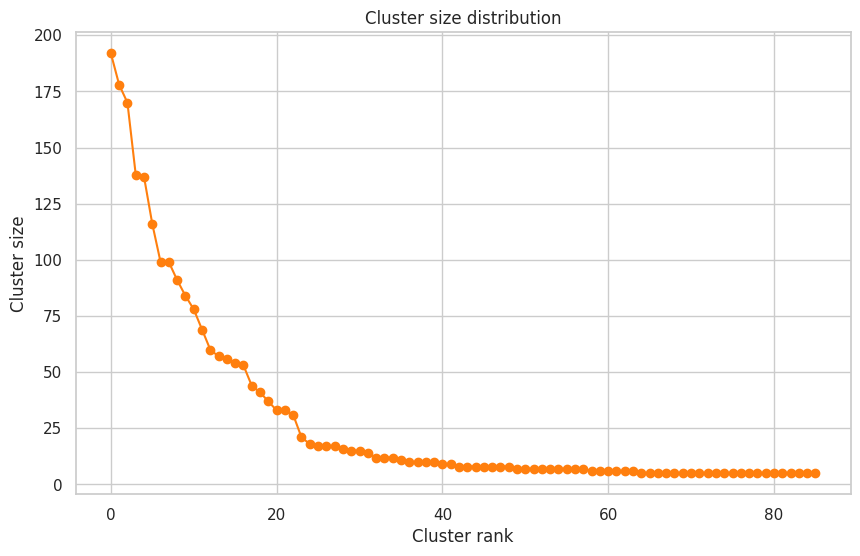

In [38]:
cluster_sizes = community_df.drop_duplicates("cluster_id")["cluster_size"].sort_values(ascending=False).reset_index(drop=True)
plt.figure()
plt.plot(range(len(cluster_sizes)), cluster_sizes, marker="o", color="#ff7f0e")
plt.xlabel("Cluster rank")
plt.ylabel("Cluster size")
plt.title("Cluster size distribution")
plt.show()


In [39]:
# Attach tag/keyword signals to clusters for purity stats
cluster_enriched = community_df.merge(
    work_df[["work_id", "tags", "keywords"]],
    on="work_id",
    how="left",
)

tag_stats = pd.DataFrame()
keyword_stats = pd.DataFrame()
if not cluster_enriched.empty:
    if "tags" in cluster_enriched.columns:
        tag_stats = summarize_signal_purity(cluster_enriched, "tags")
    if "keywords" in cluster_enriched.columns:
        keyword_stats = summarize_signal_purity(cluster_enriched, "keywords")


In [40]:
tag_share_summary = describe_percentages(tag_stats["top_term_share"]) if not tag_stats.empty else pd.Series(dtype=float)
keyword_share_summary = describe_percentages(keyword_stats["top_term_share"]) if not keyword_stats.empty else pd.Series(dtype=float)

summary_table = pd.concat(
    [
        tag_share_summary.to_frame(name="Top tag share"),
        keyword_share_summary.to_frame(name="Top keyword share"),
    ],
    axis=1,
)
summary_table


,Top tag share,Top keyword share
count,6.000,79.000
mean,0.059,0.198
std,0.074,0.143
min,0.006,0.028
25%,0.011,0.093
50%,0.015,0.167
75%,0.112,0.286
90%,0.155,0.400
max,0.167,0.600


## Success Metrics

Combine the diagnostics above into actionable indicators for the thesis results section.


In [41]:
success_metrics = {
    "embedding_coverage": float(embedding_coverage),
    "graph_coverage": float(graph_coverage) if not np.isnan(graph_coverage) else np.nan,
    "largest_component_ratio": float(largest_component_ratio) if largest_component_ratio is not None else np.nan,
    "modularity": float(modularity) if modularity is not None else np.nan,
    "median_tag_purity": float(tag_stats["top_term_share"].median()) if not tag_stats.empty else np.nan,
    "median_keyword_purity": float(keyword_stats["top_term_share"].median()) if not keyword_stats.empty else np.nan,
}

thresholds = {
    "embedding_coverage": 0.90,
    "graph_coverage": 0.30,
    "largest_component_ratio": 0.10,
    "modularity": 0.30,
    "median_tag_purity": 0.20,
    "median_keyword_purity": 0.25,
}

success_rows = []
for metric, value in success_metrics.items():
    threshold = thresholds.get(metric)
    status = None
    if threshold is not None and not np.isnan(value):
        status = value >= threshold
    success_rows.append(
        {
            "metric": metric,
            "value": value,
            "threshold": threshold,
            "meets_target": status,
        }
    )

success_df = pd.DataFrame(success_rows)

cluster_sizes = community_df.groupby("cluster_id")["work_id"].size()
component_size_summary = pd.Series(dtype=float)
if not cluster_sizes.empty:
    component_size_summary = cluster_sizes.describe(percentiles=[0.5, 0.9, 0.95])
component_size_stats = {}
for key, value in component_size_summary.items():
    component_size_stats[str(key)] = None if np.isnan(value) else float(value)
component_size_summary_df = component_size_summary.rename("cluster_size").to_frame()
component_size_summary_df.index.name = "statistic"

def quality_summary_frame(stats_df: pd.DataFrame, signal_label: str, threshold_value: float) -> dict:
    if stats_df is None or stats_df.empty or threshold_value is None or np.isnan(threshold_value):
        return {"signal": signal_label, "clusters": 0, "works": 0, "share_of_works": np.nan}
    qualified = stats_df[stats_df["top_term_share"] >= threshold_value]
    works = int(qualified["cluster_size"].sum()) if "cluster_size" in qualified.columns else int(len(qualified))
    share = works / len(work_df) if len(work_df) else np.nan
    return {
        "signal": signal_label,
        "clusters": int(len(qualified)),
        "works": works,
        "share_of_works": share,
    }

quality_summary_df = pd.DataFrame(
    [
        quality_summary_frame(tag_stats, "tags", thresholds.get("median_tag_purity")),
        quality_summary_frame(keyword_stats, "keywords", thresholds.get("median_keyword_purity")),
    ]
)

quality_summary_records = []
for record in quality_summary_df.to_dict(orient="records"):
    share = record.get("share_of_works")
    quality_summary_records.append(
        {
            "signal": record.get("signal"),
            "clusters": int(record.get("clusters", 0)),
            "works": int(record.get("works", 0)),
            "share_of_works": float(share) if share is not None and not np.isnan(share) else None,
        }
    )

display(success_df)
if not component_size_summary_df.empty:
    display(component_size_summary_df)
display(quality_summary_df)


,metric,value,threshold,meets_target
0,embedding_coverage,1.000,0.900,True
1,graph_coverage,0.347,0.300,True
2,largest_component_ratio,0.187,0.100,True
3,modularity,0.892,0.300,True
4,median_tag_purity,0.015,0.200,False
5,median_keyword_purity,0.167,0.250,False


,cluster_size
statistic,
count,86.000
mean,28.721
std,42.385
min,5.000
50%,8.000
90%,87.500
95%,131.750
max,192.000


,signal,clusters,works,share_of_works
0,tags,0,0,0.000
1,keywords,25,206,0.058


In [42]:
analysis_output = {
    "embedding_summary": embedding_summary,
    "similarity_summary": similarity_summary,
    "community_summary": community_summary,
    "success_metrics": success_metrics,
    "thresholds": thresholds,
    "additional_metrics": {
        "component_size_stats": component_size_stats,
        "quality_summary": quality_summary_records,
    },
    "parameters": {
        "component_min_size": COMPONENT_MIN_SIZE,
        "cluster_min_size": CLUSTER_MIN_SIZE,
    },
}

analysis_output["grid_results"] = grid_results.to_dict(orient="records")

analysis_dir = REPO_ROOT / "data/output/analysis"
analysis_dir.mkdir(parents=True, exist_ok=True)
(analysis_dir / "results_metrics.json").write_text(json.dumps(analysis_output, indent=2), encoding="utf-8")
print(f"Saved consolidated metrics to {analysis_dir / 'results_metrics.json'}")


Saved consolidated metrics to /mnt/personal/Documents/2. Documents/2. USP/4. TCC/literary-knowledge-network/data/output/analysis/results_metrics.json


In [43]:
df = pd.read_parquet("/home/beatriz/Documents/2. Documents/2. USP/4. TCC/literary-knowledge-network/data/output/communities/work_communities.parquet")
df.to_csv("/home/beatriz/Documents/2. Documents/2. USP/4. TCC/literary-knowledge-network/data/output/communities/work_communities.csv", index=False)


In [44]:
df = pd.read_parquet("/home/beatriz/Documents/2. Documents/2. USP/4. TCC/literary-knowledge-network/data/processed/enriched/work_final.parquet")
df.to_csv("/home/beatriz/Documents/2. Documents/2. USP/4. TCC/literary-knowledge-network/data/processed/enriched/work_final.csv", index=False)